In [6]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [39]:
task = "popu_freq"
rare_or_ultrarare = "Rare" # Rare, Ultra-rare
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50")]

# by default, we consider smaller means damaging (here rare), but the following models have specific opposite meaning
models_larger_means_damaging = ["metarnn", "mvp", "polyphen2_HVAR", "cadd", "revel"]

metrics = ["AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC"]

In [40]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")

result_df.loc[result_df["mt_freq"]>=.01, "class"] = "Common"

result_df.loc[(result_df["mt_freq"]<.01) & (result_df["mt_freq"]>=.001), "class"] = "Rare"
result_df.loc[result_df["mt_freq"]<.001, "class"] = "Ultra-rare"

result_df = result_df[(result_df["class"]=="Common") | (result_df["class"]==rare_or_ultrarare)] # common and rare only or ommon and ultra-rare only
print(result_df.shape)
print(result_df.columns)

result_df.loc[result_df["class"]=="Common", "class_numeric"] = 1
result_df.loc[result_df["class"]==rare_or_ultrarare, "class_numeric"] = 0
print("Common: ", result_df[result_df["class"]=="Common"].shape, rare_or_ultrarare, result_df[result_df["class"]==rare_or_ultrarare].shape)

(47662, 33)
Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred'],
      dtype='object')
Common:  (18279, 34) Rare (29383, 34)


### Computing all methods performance metrics

In [41]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{rare_or_ultrarare}_analysis.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
    
    non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
    
    if model_name in models_larger_means_damaging:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
    
    auc_roc_score = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
    
    permformance_scores = [auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc]
    
    out.write(f"{model_name}")
    for score in permformance_scores:
        out.write(f"\t{score:.3f}")
    out.write("\n")
        
    
    # if i==5: break

out.close()

sift
	AUC-ROC: 0.609
	AUC-PR: 0.507
	Best F1-Score: 0.543 at threshold: 0.004
	Precision score: 0.388 at threshold: 0.004
	Recall score: 0.906 at threshold: 0.004
	Accuracy score: 0.439 at threshold: 0.004
	Balanced accuracy score: 0.537 at threshold: 0.004
	MCC score: 0.102 at threshold: 0.004
polyphen2_HVAR
	AUC-ROC: 0.609
	AUC-PR: 0.522
	Best F1-Score: 0.539 at threshold: -0.985
	Precision score: 0.379 at threshold: -0.985
	Recall score: 0.933 at threshold: -0.985
	Accuracy score: 0.412 at threshold: -0.985
	Balanced accuracy score: 0.521 at threshold: -0.985


/tmp/ipykernel_2578776/861342033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2578776/861342033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	MCC score: 0.069 at threshold: -0.985
cadd
	AUC-ROC: 0.608
	AUC-PR: 0.456
	Best F1-Score: 0.553 at threshold: -0.477
	Precision score: 0.403 at threshold: -0.477
	Recall score: 0.882 at threshold: -0.477
	Accuracy score: 0.468 at threshold: -0.477
	Balanced accuracy score: 0.552 at threshold: -0.477
	MCC score: 0.130 at threshold: -0.477
mvp
	AUC-ROC: 0.592


/tmp/ipykernel_2578776/861342033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_2578776/861342033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-PR: 0.180
	Best F1-Score: 0.239 at threshold: -0.218
	Precision score: 0.158 at threshold: -0.218
	Recall score: 0.493 at threshold: -0.218
	Accuracy score: 0.643 at threshold: -0.218
	Balanced accuracy score: 0.577 at threshold: -0.218
	MCC score: 0.103 at threshold: -0.218
metarnn
	AUC-ROC: 0.758
	AUC-PR: 0.719
	Best F1-Score: 0.634 at threshold: -0.005
	Precision score: 0.562 at threshold: -0.005
	Recall score: 0.729 at threshold: -0.005
	Accuracy score: 0.687 at threshold: -0.005
	Balanced accuracy score: 0.695 at threshold: -0.005
	MCC score: 0.378 at threshold: -0.005
revel
	AUC-ROC: 0.579
	AUC-PR: 0.421
	Best F1-Score: 0.551 at threshold: -0.421
	Precision score: 0.388 at threshold: -0.421
	Recall score: 0.947 at threshold: -0.421
	Accuracy score: 0.430 at threshold: -0.421
	Balanced accuracy score: 0.538 at threshold: -0.421
	MCC score: 0.121 at threshold: -0.421
unirep
	AUC-ROC: 0.520
	AUC-PR: 0.401
	Best F1-Score: 0.554 at threshold: 0.000


/tmp/ipykernel_2578776/861342033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	Precision score: 0.384 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.384 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
protbert
	AUC-ROC: 0.531
	AUC-PR: 0.413
	Best F1-Score: 0.554 at threshold: 0.131
	Precision score: 0.384 at threshold: 0.131
	Recall score: 1.000 at threshold: 0.131
	Accuracy score: 0.384 at threshold: 0.131
	Balanced accuracy score: 0.500 at threshold: 0.131
	MCC score: 0.011 at threshold: 0.131
sequnet
	AUC-ROC: 0.484
	AUC-PR: 0.373
	Best F1-Score: 0.555 at threshold: 0.000
	Precision score: 0.384 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.384 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.004 at threshold: 0.000
esm1b_t33_650M_UR50S
	AUC-ROC: 0.565
	AUC-PR: 0.452
	Best F1-Score: 0.555 at threshold: 0.261
	Precision score: 0.385 at threshold: 0.261
	Recall score: 0.992 at threshold: 0.261
	Acc

### Computing random classifiers average performance metrics of 10 runs

In [42]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["preds"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list)]
    
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{rare_or_ultrarare}_analysis.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.509
	AUC-PR: 0.388
	Best F1-Score: 0.554 at threshold: 0.041
	Precision score: 0.384 at threshold: 0.041
	Recall score: 1.000 at threshold: 0.041
	Accuracy score: 0.384 at threshold: 0.041
	Balanced accuracy score: 0.500 at threshold: 0.041
	MCC score: 0.008 at threshold: 0.041
	AUC-ROC: 0.509
	AUC-PR: 0.388
	Best F1-Score: 0.554 at threshold: 0.041
	Precision score: 0.384 at threshold: 0.041
	Recall score: 1.000 at threshold: 0.041
	Accuracy score: 0.384 at threshold: 0.041
	Balanced accuracy score: 0.500 at threshold: 0.041
	MCC score: 0.008 at threshold: 0.041
	AUC-ROC: 0.509
	AUC-PR: 0.388
	Best F1-Score: 0.554 at threshold: 0.041
	Precision score: 0.384 at threshold: 0.041
	Recall score: 1.000 at threshold: 0.041
	Accuracy score: 0.384 at threshold: 0.041
	Balanced accuracy score: 0.500 at threshold: 0.041
	MCC score: 0.008 at threshold: 0.041
	AUC-ROC: 0.509
	AUC-PR: 0.388
	Best F1-Score: 0.554 at threshold: 0.041
	Precision score: 0.384 at threshold: 0.041
	Recall sc

/tmp/ipykernel_2578776/3851337120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-PR: 0.719
[-1.00000000e+00 -9.99411836e-01 -9.99349608e-01 ... -9.99696718e-08
 -9.96784259e-08 -0.00000000e+00] (41604,)


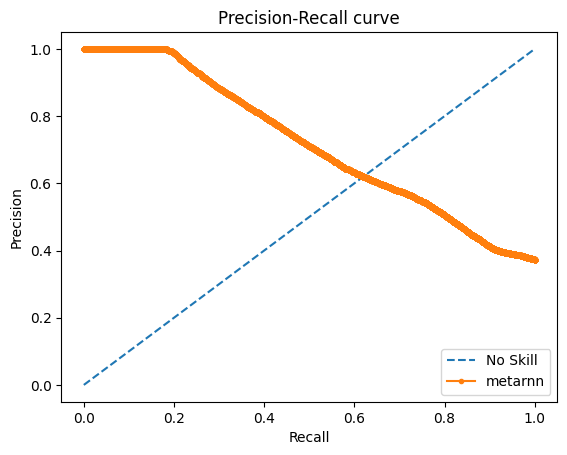

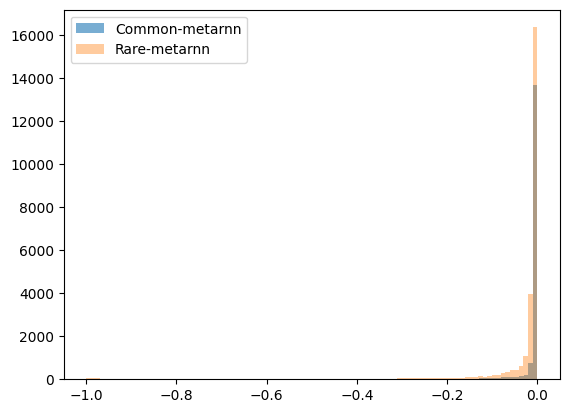

In [43]:
model_name = "metarnn"
model_pred_col = model_name + "_pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_larger_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
        
auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds, thresholds.shape)

import matplotlib.pyplot as plt
# plt.fill_between(recalls, precisions)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


common = non_nan_result_df[non_nan_result_df["class"]=="Common"]
rare = non_nan_result_df[non_nan_result_df["class"]==rare_or_ultrarare]

bins = 100 # 20, 100, 500
plt.hist(common["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Common-{model_name}")
plt.hist(rare["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Rare-{model_name}")

plt.legend()
plt.show()